**Import packages:**

In [151]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import pandas

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import PercentFormatter

# To print nicely:
sm.init_printing(use_unicode=True)

# 1. Human capital accumulation

**We define the variables used in the analysis:**

w: wage rate <br>
b: unemployment benefit <br>
$c_t$: consumption in period t <br>
$h_t$: human capital in period t <br>
$l_t$: labor supply in period t <br>
$\rho$: risk aversion coefficient <br>
$\gamma$: degree of disutility from working <br>
$\Delta$: stochastic experience gain <br>
$\beta$: discount factor

**Defining the necessary equations and the values of l.**

In [3]:
l = [0, 1]

def consumption(w,h,b,l):
    """
    If the person doesn't work (l = 0), she will recieve an unemployment benefit (b) instead of a wage income.
    If the person works (l = 1), she will receive a wage income based on the wage (w) and her human capital (h).
    """
    if l == 0:
        c = b
    elif l == 1:
        c = w*h
    return c

def utility(rho,h,w,b,l):
    return consumption(w,h,b,l)**(1-rho)/(1-rho)

def disutility(l,gamma):
    return gamma*l

def v2(l2,h2,w,b,rho,gamma):
    return utility(rho,h2,w,b,l2) - disutility(l2,gamma)

**Setting parameter values:**

In [4]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [5]:
def solve_period_2(w,b,rho,gamma):
    """
    The function solves the utility maximizing problem in period 2 for different values of human capital in period 2.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """
    # a. grids
    h2_vec = np.linspace(0.1,1.5,100)
    l2_vec = np.empty(100)
    c2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h2 in enumerate(h2_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v2_0 = v2(l[0],h2,w,b,rho,gamma)
        v2_1 = v2(l[1],h2,w,b,rho,gamma)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v2_vec[i] = max(v2_0,v2_1)
        l2_vec[i] = v2_1 > v2_0
        c2_vec[i] = consumption(w,h2,b,l2_vec[i])
        
    return h2_vec,v2_vec,l2_vec,c2_vec

In [6]:
# solving for period 2 and assigning values to different vectors.
h2_vec,v2_vec,l2_vec,c2_vec = solve_period_2(w,b,rho,gamma);

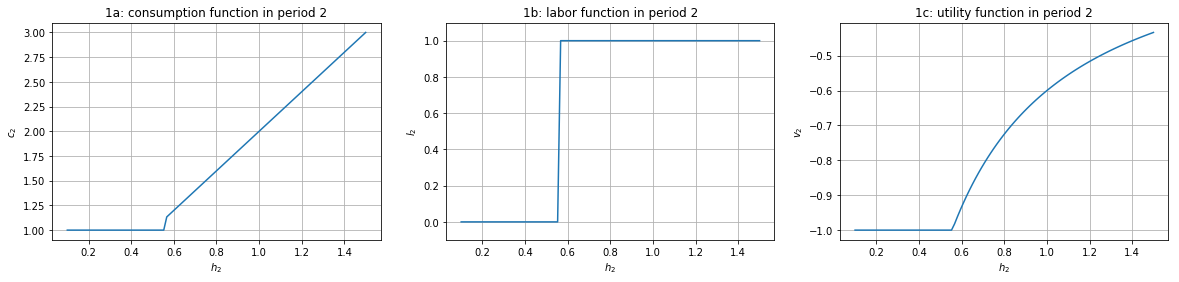

In [7]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the utility maximizing problem in period 2.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h2_vec,c2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$c_2$')
ax.set_title('1a: consumption function in period 2')

ax = fig.add_subplot(1,3,2)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$l_2$')
ax.set_title('1b: labor function in period 2')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h2_vec,v2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$v_2$')
ax.set_title('1c: utility function in period 2');

**Identifying the level of human capital necessary for the individual to work:**

In [8]:
index = np.where(l2_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h2_vec[index],3)))

She chooses to work when h ≥ 0.567


**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

**Construct interpolator:**

In [9]:
# Defining an interpolating function based on data from figure 1c.
v2_interp = interpolate.RegularGridInterpolator([h2_vec], v2_vec, bounds_error=False,fill_value=None)

***Defining $v_1$:*** <br>
We use the interpolated function to define the expected utility in period 2, accounting for two possible scenarios, <br> one scenario with a stochastic experience gain to the human capital in period 2 and one without.

In [10]:
def v1(l1,h1,w,b,rho,gamma,beta,Delta,v2_interp):
    
    # a. v2 value without a stochastic experience gain
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # b. v2 value with a stochastic experience gain
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected value of v2
    v2 = 0.5 * v2_low + 0.5 * v2_high
    
    # d. total value
    return utility(rho,h1,w,b,l1) - disutility(l1,gamma) + beta*v2

In [11]:
def solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp):
    """
    The function solves the intertemporal utility maximizing problem in period 1,
    for different values of human capital in period 1 considering both periods.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """ 
    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    l1_vec = np.empty(100)
    c1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v1_0 = v1(l[0],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        v1_1 = v1(l[1],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v1_vec[i] = max(v1_0,v1_1)
        l1_vec[i] = v1_1 > v1_0
        c1_vec[i] = consumption(w,h1,b,l1_vec[i])
        
    return h1_vec,v1_vec,l1_vec,c1_vec

In [12]:
# solving for period 1 and assigning values to different vectors.
h1_vec,v1_vec,l1_vec,c1_vec = solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp)

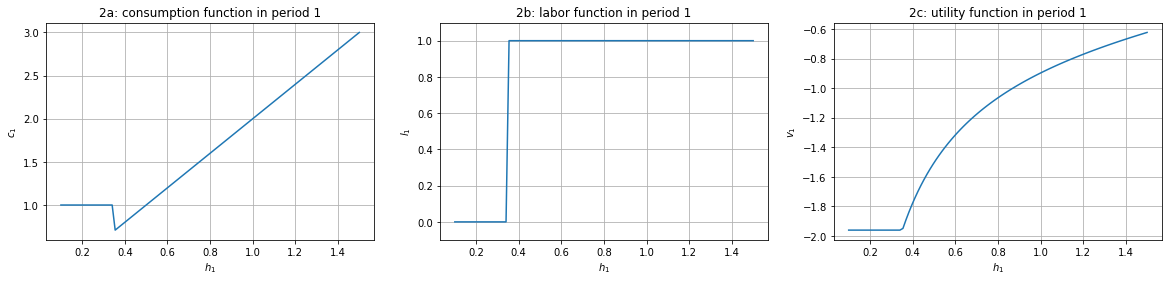

In [13]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the intertemporal utility maximizing problem in period 1.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h1_vec,c1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$c_1$')
ax.set_title('2a: consumption function in period 1')

ax = fig.add_subplot(1,3,2)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$l_1$')
ax.set_title('2b: labor function in period 1')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h1_vec,v1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$v_1$')
ax.set_title('2c: utility function in period 1');

**Identifying the level of human capital necessary for the individual to work:**

In [14]:
index = np.where(l1_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h1_vec[index],3)))

She chooses to work when h ≥ 0.355


**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

As can be seen in figure 2a the worker will choose to work even though her potential wage income is lower than the unemployment benefit, i.e. her consumption is lower when she chooses to work.
The reason for this, is that she improves her human capital in period 2 by working in period 1. This will then improve her consumption more in period 2 than it reduces her consumption in period 1.

# 2. AS-AD model

**Defining symbols:**

In [15]:
pi = sm.symbols("pi_t")
y = sm.symbols("y_t")
pi_e = sm.symbols("pi^e_t")
s = sm.symbols("s_t")
v = sm.symbols("v_t")
pi1 = sm.symbols("pi_t-1")
y1 = sm.symbols("y_t-1")
s1 = sm.symbols("s_t-1")
pistar = sm.symbols("pi^*")
ystar = sm.symbols("y^*")
alpha = sm.symbols("alpha")
gamma = sm.symbols("gamma")
phi = sm.symbols("phi")
h = sm.symbols("h")
b = sm.symbols("b")

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Defining our AD-curve:**

In [16]:
AD = sm.Eq(pi,(v - (1 + b*alpha)*y)/(h*alpha))
AD

**Defining our SRAS-curve:**

In [17]:
SRAS = sm.Eq(pi,pi1 + gamma*y - phi*gamma*y1 + s - phi*s1)
SRAS

**Finding equilibrium values for output gap, $y_t$, and inflation gap, $\pi_t$:**

In [18]:
# Solving
Eq = sm.solve([AD, SRAS], [y, pi])
pi_eq = Eq[pi]
y_eq = Eq[y]

# Creating functions of pi and y for later use
pi_func = sm.lambdify((pi1, y1, v, s, s1, alpha, h, b, phi, gamma), pi_eq)
y_func = sm.lambdify((pi1, y1, v, s, s1, alpha, h, b, phi, gamma), y_eq)

**Output gap:**

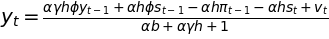

In [19]:
sm.Eq(y,y_eq)

**Inflation gap:**

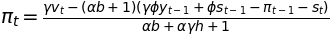

In [20]:
sm.Eq(pi,pi_eq)

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Setting the parameters of the model:**

In [324]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Assigning values to variables:**

In [317]:
y1 = 0
pi1 = 0
s = 0
s1 = 0
v_vec = [0,0.1]
y_vec = np.linspace(-2,2,40)

**Calculating $\pi_t$ and $y_t$ for $v_t$ = 0 and $v_t$ = 0.1:**

In [345]:
# creating empty arrays for pi, y and our supply and demand curves
SRAS_vec = []
AD1_vec = []
AD2_vec = []
pi_result = []
y_result = []

# calculating pi, y and our supply and demand curves
for y in y_vec:
    SRAS_vec.append(par['gamma']*y)
    AD1_vec.append((v_vec[0] - (1 + par['b']*par['alpha'])*y)/(par['h']*par['alpha']))
    AD2_vec.append((v_vec[1] - (1 + par['b']*par['alpha'])*y)/(par['h']*par['alpha']))
    
for val in v_vec:
    pi_result.append(pi_func(0,0,val,0,0,par['alpha'],par['h'],par['b'],par['phi'],par['gamma']))
    y_result.append(y_func(0,0,val,0,0,par['alpha'],par['h'],par['b'],par['phi'],par['gamma']))

**Plotting the results and marking equilibrium points:**

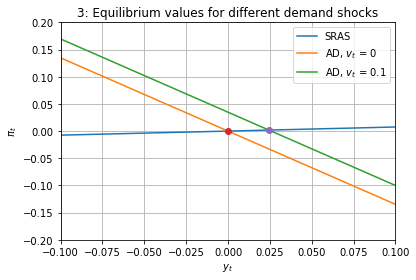

In [346]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(y_vec, SRAS_vec, label='SRAS')
ax.plot(y_vec, AD1_vec, label='AD, $v_t$ = 0')
ax.plot(y_vec, AD2_vec, label='AD, $v_t$ = 0.1')
ax.plot(y_result[0], pi_result[0], marker='o')
ax.plot(y_result[1], pi_result[1], marker='o')
ax.grid()
ax.legend()
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.set_xlim([-0.1,0.1])
ax.set_ylim([-0.2,0.2])
ax.set_title('3: Equilibrium values for different demand shocks');

In [354]:
# creating a table with the equilibrium values of y and pi for the different values of v
headers = ["v = 0", "v = 0.1"]
rows = ["$\pi_t$", "$y_t$"]
data = np.array([[pi_result[0],pi_result[1]],[y_result[0],y_result[1]]])
pandas.DataFrame(data,rows,headers)

,v = 0,v = 0.1
$\pi_t$,0.0,0.001831
$y_t$,0.0,0.024414


We can see that a positive demand shock increases both inflation gap and output gap but the output gap increases the most.

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Defining functions for demand and supply shocks:**

In [26]:
v_func = lambda v1,x: delta*v1 + x
s_func = lambda s1,c: omega*s1 + c

**Setting new parameter values:**

In [27]:
delta = par['delta'] = 0.80
omega = par['omega'] = 0.15

**Creating empty vectors for initial values:**

In [28]:
pi_vec_q3 = [0]
y_vec_q3 = [0]
v_vec = [0]
s_vec = [0]

**Choosing the period length and defining x and c for each period:**

In [356]:
T = 7
c = np.zeros(T)
x = np.zeros(T)

# setting x0 value
x[1] = 0.1

**Running the simulation and appending values to vectors:**

In [357]:
# creating a dataframe to present the results
output = pandas.DataFrame(index=np.arange(0,T-1),columns=('t','$\pi_t$', '$y_t$'))

# looping through the periods
for t in range(1,T):
    
    # i. update v and s
    v_vec.append(v_func(v_vec[t-1], x[t]))
    s_vec.append(s_func(s_vec[t-1], c[t]))
    
    # ii. compute y og pi
    y_vec_q3.append(y_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], par['phi'], par['gamma']))
    pi_vec_q3.append(pi_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], par['phi'], par['gamma']))
    
    # appending y and pi values to our dataframe
    output.iloc[t-1] = [t-2, round(pi_vec_q3[t-1],4), round(y_vec_q3[t-1],4)]

# removing the index column and printing the output table
blankIndex=[''] * len(output)
output.index=blankIndex
output

,t,$\pi_t$,$y_t$
,-1,0,0
,0,0.0018,0.0244
,1,0.0032,0.0182
,2,0.0042,0.0134
,3,0.0049,0.0095
,4,0.0054,0.0065


**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**The standard deviation of the shocks are:**

In [358]:
sigma_x = par['sigma_x'] = 3.492
sigma_c = par['sigma_c'] = 0.2

**Defining stochastic process:**

In [371]:
# number of periods
T = 1000

# seed number
np.random.seed(2019)

# creating x and c vectors
x = np.random.normal(0,sigma_x,T)
c = np.random.normal(0,sigma_c,T)

def simulation(T,phi_custom):

    # creating pi, y, v and s vectors with initial values
    pi_vec_q4 = [0]
    y_vec_q4 = [0]
    v_vec = [0]
    s_vec = [0]

    for t in range(1,T):
    
        # i. update v and s
        v_vec.append(v_func(v_vec[t-1], x[t]))
        s_vec.append(s_func(s_vec[t-1], c[t]))
    
        # ii. compute y and pi
        y_vec_q4.append(y_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], phi_custom, par['gamma']))
        pi_vec_q4.append(pi_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], par['alpha'],
                           par['h'], par['b'], phi_custom, par['gamma']))
    
    # convert lists to numpy arrays
    pi_vec_q4 = np.array(pi_vec_q4)
    y_vec_q4 = np.array(y_vec_q4)
    
    # saving the correlation coefficient
    stats_q4 = []
    stats_q4.append(y_vec_q4.var())
    stats_q4.append(pi_vec_q4.var())
    stats_q4.append(np.corrcoef(y_vec_q4, pi_vec_q4)[1,0])
    stats_q4.append(np.corrcoef(y_vec_q4[1:], y_vec_q4[:-1])[1,0])
    stats_q4.append(np.corrcoef(pi_vec_q4[1:], pi_vec_q4[:-1])[1,0])
    
    return y_vec_q4, pi_vec_q4, stats_q4

y_vec_q4, pi_vec_q4, stats_q4 = simulation(T, par['phi'])

In [375]:
# creating a dataframe with the statistics and printing the output table
row_q4 = ['Var($y_t$)', 'Var($\pi_t$)', 'corr($y_t,\pi_t$)', 'corr($y_t,y_t-1$)','corr($\pi_t,\pi_t-1$)']
header_q4 = ['']
stats = pandas.DataFrame(stats_q4,row_q4,header_q4)
stats

,
Var($y_t$),1.960337
Var($\pi_t$),0.964009
"corr($y_t,\pi_t$)",-0.163420
"corr($y_t,y_t-1$)",0.767174
"corr($\pi_t,\pi_t-1$)",0.976682


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Creating a vector containing different values of $\phi$:**

In [369]:
phi_q5 = np.linspace(0,1,50)

**Running the simulation for different values of $\phi$:**

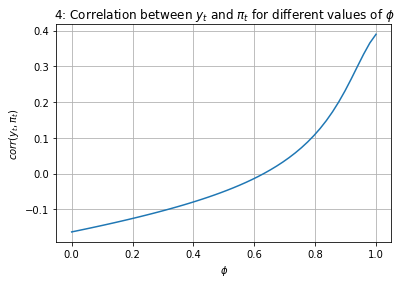

In [376]:
# creating an empty list
corr = []

# looping through values of phi and appending correlation coefficients to empty list, corr
for p in phi_q5:
    y_vec_q4, pi_vec_q4, stats_q4 = simulation(T, p)
    corr.append(stats_q4[2])

# plotting the correlation coefficients as a function of phi
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(phi_q5,corr)
ax.grid()
ax.set_xlabel('$\phi$')
ax.set_ylabel('$corr(y_t,\pi_t)$')
ax.set_title('4: Correlation between $y_t$ and $\pi_t$ for different values of $\phi$');

**Defining the objective function that we want to minimize:**

In [364]:
# The function defines the difference between the simulated correlation coefficient and the desired coefficient
obj = lambda phi: simulation(T,phi)[2][2] - 0.31

**Using a root finder to identify the value of $\phi$ that minimizes the objective function:**

In [377]:
# run the root finder and save the optimal phi value
phi_opt = optimize.root(obj, x0 = 0.9)
phi_opt = phi_opt.x

# print results
print('The value of phi that generates the desired correlation coefficient is: ' + str(round(phi_opt[0],2)))
print('Check for correct correlation coefficient. Corr: ' + str(round(simulation(T,phi_opt)[2][2],2)))

The value of phi that generates the desired correlation coefficient is: 0.94
Check for correct correlation coefficient. Corr: 0.31


**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

**Creating array with the above values:**

In [115]:
stats_comparison = np.array([1.64, 0.21, 0.31, 0.84, 0.48])

In [141]:
def simulation_q6(params):
    
    # defining params
    p, sigma_x_custom, sigma_c_custom = params
    
    # creating x and c vectors
    x = np.random.normal(0,sigma_x_custom,T)
    c = np.random.normal(0,sigma_c_custom,T)
    
    # run the simulation
    y_vec_q6, pi_vec_q6, stats_q6 = simulation(T, p)
    
    # changing stats_q6 to a numpy array
    stats_q6 = np.array(stats_q6)
    
    # calculating distance
    dist = np.linalg.norm(stats_q6, stats_comparison)
    
    return dist

**Defining the objective function that we want to minimize:**

In [142]:
# initial guess
x0 = [1,1,1]

# setting parameter bounds
bnds = ((0,1),(0,None),(0,None))

**Using a numerical optimizer to identify the value of $\phi$, $\sigma_x$ and $\sigma_c$ that minimizes the objective function:**

In [143]:
params_opt = optimize.minimize(simulation_q6, x0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 3. Exchange economy

The **parameters** and **random preferences and endowments** are given by:

In [149]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

From the Cobb-Douglas utility function we can see that the budget shares are the beta values.
Therefore we plot the beta values in histograms below

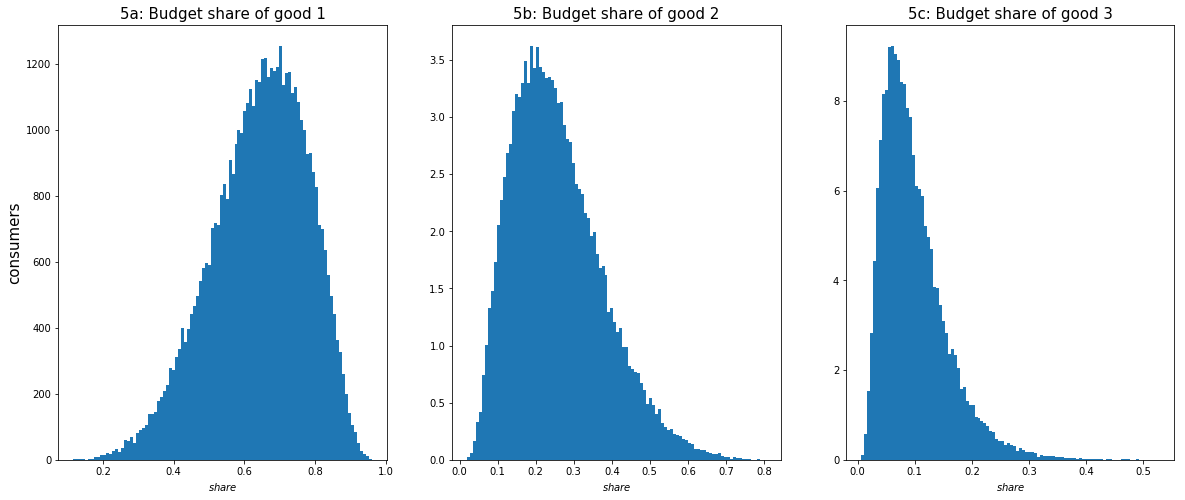

In [187]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,3,1)
ax.hist(betas[:,0],bins=100,histtype='bar')
ax.set_xlabel('$share$')
ax.set_ylabel('consumers', fontsize=15)
ax.set_title('5a: Budget share of good 1', fontsize=15)

ax = fig.add_subplot(1,3,2)
ax.hist(betas[:,1],bins=100,density=True,histtype='bar')
ax.set_xlabel('$share$')
ax.set_title('5b: Budget share of good 2', fontsize=15)

ax = fig.add_subplot(1,3,3)
ax.hist(betas[:,2],bins=100,density=True,histtype='bar')
ax.set_xlabel('$share$')
ax.set_title('5c: Budget share of good 3', fontsize=15);

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Defining the demand functions and excess demand function for good 1, 2 and 3:**

In [246]:
# demand functions. We exclude p3 as it is normalized to 1
def demand_good_1(betas,p1,p2,e1,e2,e3):
    
    # i. income
    I = p1*e1 + p2*e2 + e3
    
    # ii. demand
    d1 = betas[:,0] * I/p1
    
    return d1

def demand_good_2(betas,p1,p2,e1,e2,e3):
    
    # i. income
    I = p1*e1 + p2*e2 + e3
    
    # ii. demand
    d2 = betas[:,1] * I/p2
    
    return d2

def demand_good_3(betas,p1,p2,e1,e2,e3):
    
    # i. income
    I = p1*e1 + p2*e2 + e3
    
    # ii. demand
    d3 = betas[:,2] * I
    
    return d3

# excess demand functions
def excess_demand_good_1(betas,p1,p2,e1,e2,e3):
    
    # total demand for good 1
    total_d1 = np.sum(demand_good_1(betas,p1,p2,e1,e2,e3))
    
    # total supply of good 1
    total_e1 = np.sum(e1)
    
    # excess demand of good 1
    excess_1 = total_d1 - total_e1
    
    return excess_1

def excess_demand_good_2(betas,p1,p2,e1,e2,e3):
    
    # total demand for good 2
    total_d2 = np.sum(demand_good_2(betas,p1,p2,e1,e2,e3))
    
    # total supply of good 2
    total_e2 = np.sum(e2)
    
    # excess demand of good 2
    excess_2 = total_d2 - total_e2
    
    return excess_2

# creating price arrays
p1_a = np.linspace(0.1,10,100)
p2_a = np.linspace(0.1,10,100)

# creating empty grids for excess demands
excess_grid_1 = np.empty((100,100))
excess_grid_2 = np.empty((100,100))

# creating grids from our price vectors
p1_grid, p2_grid = np.meshgrid(p1_a, p2_a)

# calculating excess demand for different prices
for i,p1 in enumerate(p1_a):
    for j,p2 in enumerate(p2_a):
        excess_grid_1[i,j] = excess_demand_good_1(betas,p1,p2,e1,e2,e3)
        excess_grid_2[i,j] = excess_demand_good_2(betas,p1,p2,e1,e2,e3)

**Plotting the excess demand curves for good 1 and good 2:**

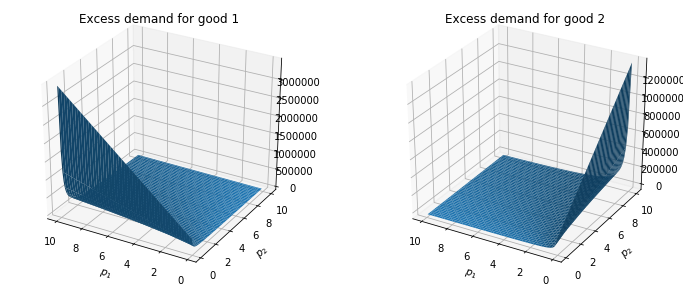

In [247]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(p1_grid, p2_grid, excess_grid_1)
ax.invert_xaxis()
ax.set_title('Excess demand for good 1')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(p1_grid, p2_grid, excess_grid_2)
ax.invert_xaxis()
ax.set_title('Excess demand for good 2')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$');

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Guessing initial values:**

In [248]:
p1_0 = 1
p2_0 = 1

**Defining equilibrium function:**

In [378]:
def equilibrium(betas,p1,p2,e1,e2,e3,kappa=0.5,eps=1e-6,maxiter=10000):
    
    t=0
    while True:
        
        # i. step 2: calculate excess demand
        z1 = excess_demand_good_1(betas,p1,p2,e1,e2,e3)
        z2 = excess_demand_good_2(betas,p1,p2,e1,e2,e3)
        
        # ii. step 3: stop?
        if (np.abs(z1) < eps and np.abs(z2) < eps) or t >= maxiter:
            print(f'Iteration nr. {t}: (p1, p2) = ({p1:.2f}, {p2:.2f}) => excess demand (z1, z2) = ({z1:.2f}, {z1:.2f})')
            break
            
        # iii. step 4: update prices and return to step 2
        p1 = p1 + kappa*z1/N
        p2 = p2 + kappa*z2/N
        
        # next iteration
        t += 1
        
    return p1, p2

In [379]:
# running the equilibrium function and saving equilibrium prices
p1, p2 = equilibrium(betas,p1_0,p2_0,e1,e2,e3)

Iteration nr. 2342: (p1, p2) = (6.49, 2.62) => excess demand (z1, z2) = (0.00, 0.00)


**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Defining utility function:**

In [294]:
def utility_func(betas,p1,p2,e1,e2,e3,gamma):
    
    # i. creating demand functions
    d1 = demand_good_1(betas,p1,p2,e1,e2,e3)
    d2 = demand_good_2(betas,p1,p2,e1,e2,e3)
    d3 = demand_good_3(betas,p1,p2,e1,e2,e3)
    
    # ii. creating an empty array for utility values
    u = np.zeros(N-1)
    
    # iii. calculating utility for each individual
    for i in range(0,N-1):
        u[i] = (d1[i]**betas[i,0]*d2[i]**betas[i,1]*d3[i]**betas[i,2])**gamma
        
    
    # Calculating mean and variance of utility
    u_mean = np.mean(u)
    u_var = np.var(u)
    
    # printing mean and variance
    print(f'Mean(u) = {u_mean:.3f}')
    print(f'Var(u) = {u_var:.3f}')
        
    return u

In [380]:
# running the utility function
u = utility_func(betas,p1,p2,e1,e2,e3,gamma)

Mean(u) = 1.010
Var(u) = 0.317


**Plotting the utility distribution:**

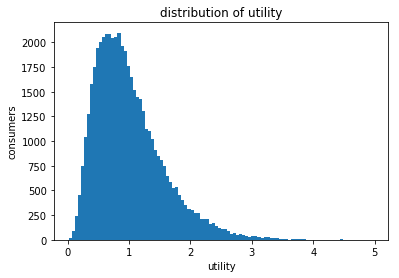

In [381]:
plt.hist(u,bins=100)
plt.title('distribution of utility')
plt.xlabel('utility')
plt.ylabel('consumers');

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

**Defining new and equally distributed endowments based on the original total endowments:**

In [297]:
e1_new = np.ones(N) * np.sum(e1)/N
e2_new = np.ones(N) * np.sum(e2)/N
e3_new = np.ones(N) * np.sum(e3)/N

**Calculating equilibrium prices and utility values for new endowments and different $\gamma$ values:**

In [303]:
p1_new, p2_new = equilibrium(betas,p1_0,p2_0,e1_new,e2_new,e3_new)
u_new = utility_func(betas,p1_new,p2_new,e1_new,e2_new,e3_new,gamma)
u_new_newgamma = utility_func(betas,p1_new,p2_new,e1_new,e2_new,e3_new,2)

Iteration nr. 2339: (p1, p2) = (6.49, 2.62) => excess demand (z1, z2) = (0.00, 0.00)
Mean(u) = 1.046
Var(u) = 0.003
Mean(u) = 1.126
Var(u) = 0.027


**Plotting the different utility distributions:**

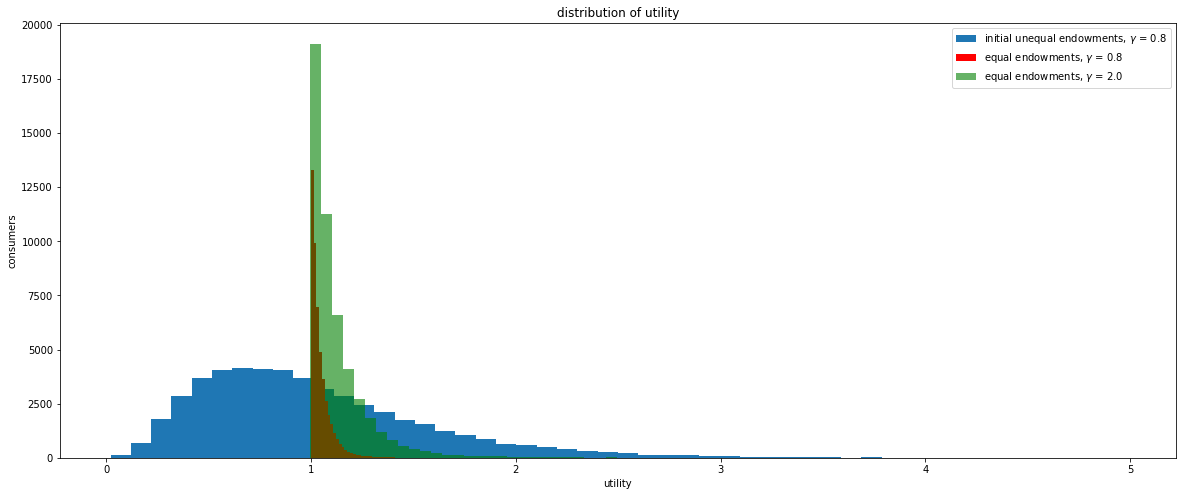

In [312]:
fig = plt.figure(figsize=(20,8))
plt.hist(u, bins=50, label='initial unequal endowments, $\gamma$ = 0.8')
plt.hist(u_new, bins=50, color='red', label='equal endowments, $\gamma$ = 0.8')
plt.hist(u_new_newgamma, bins=50, alpha=0.6, color='green', label='equal endowments, $\gamma$ = 2.0')
plt.legend()
plt.title('distribution of utility')
plt.xlabel('utility')
plt.ylabel('consumers');

The distribution of endowments has no effect on prices. However, the mean utility is higher when initial endowments
are equally distributed, and the variance is lower. <br>
When we increase gamma both the mean utility and the variance increases, so higher average utility but greater inequality.